# Streamlit을 활용해서 RAG 시스템 구축하기
langchain 라이브러리를 통해 구축해보자~

- 참고: https://www.youtube.com/watch?v=xYNYNKJVa4E (모두의AI 짱!)

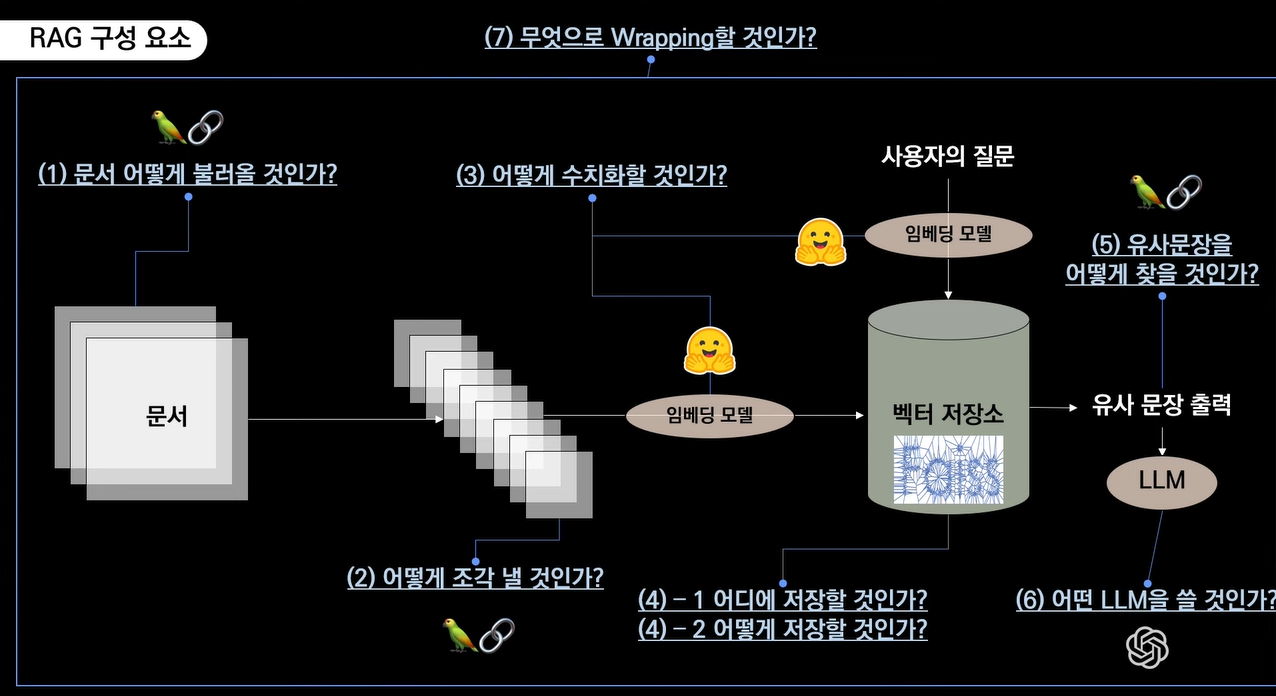

In [2]:
from IPython.display import Image
Image("RAG 구조.png")

pip install streamlit

pip install tiktoken

pip install langchain

### tikoken
- 텍스트 파일을 청크로 나눌 때 문자의 개수를 무엇을 기준으로 산정을 할 것인지에 대한 부분을 토큰 개수로 셀 것임
- 따라서 **tikoken** 은 토큰 개수를 세기 위한 라이브러리

### loguru
- streamlit 웹사이트에서 어떤 행동을 취했을 때, 구동한 것이 로그로 남도록 하기 위한 라이브러리

## langchain

### ConversationalRetrievalChain
- 메모리를 가지고 있는 체인

### ConversationBufferMemory
- 몇 개까지의 대화를 내가 메모리로 넣어줄 것인지를 결정하는 부분

### ChatOpenAI
- 오픈AI의 API를 가져오기 위함

### document_loaders
- 여러 유형의 문서들을 여러 개 집어넣어도 이들을 모두 이해시킬 수 있는 POC를 만들것이다~
- 그래서 종류별로 다 불렀음

### RecursiveCharacterTextSplitter
- 토큰을 자르는 splitter

### HuggingFaceEmbeddings
- 한국어에 특화된 임베딩 모델

### FAISS
- 임시로 벡터를 저장하는 벡터 스토어 

In [1]:
import streamlit as st
import tiktoken
from loguru import logger

from langchain.chains import ConversationalRetrievalChain
from langchain.chat_models import ChatOpenAI

from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders import Docx2txtLoader
from langchain.document_loaders import UnstructuredPowerPointLoader

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings

from langchain.memory import ConversationBufferMemory
from langchain.vectorstores import FAISS

# from streamlit_chat import message
from langchain.callbacks import get_openai_callback
from langchain.memory import StreamlitChatMessageHistory

## 메인 함수
1) 버튼을 누르면, 업로드된 파일들을 텍스트로 변환하고, 벡터화 시키고, 입력된 openAI의 API key를 통해, LLM을 불러와서, 모든 것들을 하나의 체인으로 엮을 것임!
2) 채팅화면을 구성하기 위한 코드: 전에 했던 대화들도 유지가 되게끔 할 것임
3) 질문 창을 구성하는 코드

In [ ]:
def main():
    st.set_page_config(
    page_title="MJ_Chat", # 웹페이지 탭 이름
    page_icon=":heart-pulse:") # 웹페이지 탭 아이콘, :쓰면 아이콘이 들어간다

    st.title("_Private Data :red[QA Chat]_ :books:") # 웹페이지 제목, _를 쓰면 기울기체로 된다

    ### 1
    # session_state.conversation라는 변수를 사용하기 위해서 이런 식으로 정의를 해줘야함
    if "conversation" not in st.session_state: # session_state에 conversation이 없으면, 
        st.session_state.conversation = None # session_state의  conversation을 None으로 설정

    # session_state.chat_history 또한 채팅 히스토리를 저장하기 위함
    if "chat_history" not in st.session_state:
        st.session_state.chat_history = None

    if "processComplete" not in st.session_state:
        st.session_state.processComplete = None

    # with문: 어떤 구성 요소 안에 하위 구성 요소들이 집행돼야하는 경우에 활용됨
    # 사이드 바를 만드는 코드
    with st.sidebar:
        uploaded_files =  st.file_uploader("Upload your file",type=['pdf','docx'],accept_multiple_files=True # file_uploader: 파일 업로더 기능을 넣음
        openai_api_key = st.text_input("OpenAI API Key", key="chatbot_api_key", type="password") # text_input: 오픈AI의 API를 작성하도록 함
        process = st.button("Process") # button: 버튼을 만듦

    # 만약에 process라는 버튼을 누르면~ 구동되는 부분
    if process:
        if not openai_api_key: # openAI의 API가 입력되어있지 않으면, 아래 문구를 출력하도록 함
            st.info("Please add your OpenAI API key to continue.")
            st.stop()
        files_text = get_text(uploaded_files) # 입력되어 있다면, get_text를 통해 업로드된 파일들을 텍스트로 변환
        text_chunks = get_text_chunks(files_text) # 텍스트로 변환된 파일들의 문구들을 청크로 나누기 위함
        vetorestore = get_vectorstore(text_chunks) # 벡터화 시킴
     
        st.session_state.conversation = get_conversation_chain(vetorestore,openai_api_key)  # 벡터 스토어를 갖고 LLM이 답변을 할 수 있도록 체인을 구성

        st.session_state.processComplete = True

    ### 2 
    if 'messages' not in st.session_state: # 먼저 아래와 같은 문구를 출력함으로써, UI적으로 친숙한 화면을 만들 수 있음
        st.session_state['messages'] = [{"role": "assistant", 
                                        "content": "안녕하세요! 주어진 문서에 대해 궁금하신 것이 있으면 언제든 물어봐주세요!"}]

    # 어떤 역할을 맡은 아이콘을 함께 표시를 해주고, 컨테이너 안에 content에 해당하는 텍스트를 적기 위함 
    # 한 번 메세지가 입력될때마다, 하나의 content로 엮음
    # for문으로 구성했기 때문에, 메세지가 하나 올라올때 마다 아래 코드를 수행함
    for message in st.session_state.messages: # session_state.messages에서 message들마다 
        with st.chat_message(message["role"]): # with문으로 묶어줄거다
            st.markdown(message["content"]) # message의 role에 따라서 메세지의 content를 마크다운 할거다!

    # LLM이 메모리를 갖고, context를 고려해서 답변하기 위함
    history = StreamlitChatMessageHistory(key="chat_messages")

    ### 3
    # Chat logic
    # 사용자가 질문을 입력하면, if문을 시작함
    if query := st.chat_input("질문을 입력해주세요."):
        st.session_state.messages.append({"role": "user", "content": query}) # 질문을 하게 된다면, 갖고있는 session_state.messages에 user의 role을 처음 추가

        # content로는 query를 날려주게 됨 > 첫 번째 질문이 query가 된다는 뜻
        # 질문이 입력되면, session_state.messages
        with st.chat_message("user"): # user라는 표시는 아이콘을 통해서 확인할 수 있음
            st.markdown(query) # 보낸 질문을 마크다운 

        # 사용자의 질문을 받아서 어시스턴트가 대답
        with st.chat_message("assistant"):
            chain = st.session_state.conversation

            # 로딩할때 동그라미가 돌아가는 부분
            with st.spinner("Thinking..."):
                result = chain({"question": query})
                with get_openai_callback() as cb:
                    st.session_state.chat_history = result['chat_history']  # 채팅 기록 저장
                response = result['answer']
                source_documents = result['source_documents'] # 참고한 문서 저장

                st.markdown(response)
                with st.expander("참고 문서 확인"): # 참고 문서를 접었다 폈다 표시하는 부분
                    st.markdown(source_documents[0].metadata['source'], help = source_documents[0].page_content)
                    st.markdown(source_documents[1].metadata['source'], help = source_documents[1].page_content)
                    st.markdown(source_documents[2].metadata['source'], help = source_documents[2].page_content)
                    


        # Add assistant message to chat history
        # 어시스턴트가 답변한 것도 기록
        st.session_state.messages.append({"role": "assistant", "content": response})

---
## 유틸리티 함수

In [ ]:
# 토큰 개수를 기준으로 splitting 해주는 함수 
def tiktoken_len(text):
    tokenizer = tiktoken.get_encoding("cl100k_base")
    tokens = tokenizer.encode(text)
    return len(tokens)

- 로컬 파일인 경우에는 파일이 저장된 경로를 넣어주면 로딩이 됨
- 그러나 streamlit의 경우, 클라우드 상에서 작동이 되는데, 사람들이 자신의 파일을 넣었을 때, 그 파일들에 대해서 채팅이 가능하도록 만드는 것
- streamlit 클라우드 상에서 돌아가는 임시 저장 경로를 제공 > 빈 파일이 생기게 됨 > 빈 파일에 진짜로 불러온 업로드한 파일의 값을 넣어줌
- 우회적으로 업로드한 파일의 값을 넣을 수 있게 됨

In [ ]:
# 업로드된 파일들을 모두 텍스트로 변환하는 함수 
def get_text(docs):

    doc_list = []
    
    for doc in docs:
        file_name = doc.name  # doc 객체의 이름을 파일 이름으로 사용
        with open(file_name, "wb") as file:  # 파일을 doc.name으로 저장
            file.write(doc.getvalue())
            logger.info(f"Uploaded {file_name}")
        if '.pdf' in doc.name:
            loader = PyPDFLoader(file_name)
            documents = loader.load_and_split()
        elif '.docx' in doc.name:
            loader = Docx2txtLoader(file_name)
            documents = loader.load_and_split()
        elif '.pptx' in doc.name:
            loader = UnstructuredPowerPointLoader(file_name)
            documents = loader.load_and_split()

        doc_list.extend(documents) # doc_list에 담아서 하나의 다큐먼트 목록을 만들어서 리턴해줌
    return doc_list

In [ ]:
# 여러 청크들로 split하는 과정
def get_text_chunks(text):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=900, # 토큰 개수를 기준으로 900 사이즈를 갖는 청크로 나눠줌
        chunk_overlap=100, # 앞 뒤로 겹치는 부분을 100씩 만들어줌
        length_function=tiktoken_len
    )
    chunks = text_splitter.split_documents(text) # 여러개의 청크들로 splitting 함
    return chunks

#### 임베딩 하는 과정
- 텍스트들을 수치화하기 위해 필요한 것이 임베딩 모델임
- ko-sroberta-multitask: 허깅 페이스에 있는 임베딩 모델
- FAISS: 벡터 저장소
- 어떤 텍스트들이 FAISS 벡터 저장소를 정리할지 말해주기 위해서 입력 받은 매개 변수인 text_chunks를 넣고, 위에서 정의한 임베딩 모델을 넣어주면, 텍스트 청크에 대해서 임베딩 모델로 수치화하는 과정이 아래 함수로 실행됨

In [ ]:
# 벡터 스토어 함수
def get_vectorstore(text_chunks):
    embeddings = HuggingFaceEmbeddings(
                                        model_name="jhgan/ko-sroberta-multitask",
                                        model_kwargs={'device': 'cpu'}, # streamlit 클라우드 상에서 돌아가는 pc는 GPU가 없어서 CPU로
                                        encode_kwargs={'normalize_embeddings': True} # 벡터 저장소에 저장을 해서 사용자의 질문과 비교하기 위해 
                                        )  
    vectordb = FAISS.from_documents(text_chunks, embeddings) 
    return vectordb 

위에서 선언한 모든 것들을 다 담는 함수
- ConversationBufferMemory: chat_history라는 키 값을 메모리로 저장할 것임

In [ ]:
def get_conversation_chain(vetorestore,openai_api_key):
    llm = ChatOpenAI(openai_api_key=openai_api_key, model_name = 'gpt-3.5-turbo',temperature=0)
    conversation_chain = ConversationalRetrievalChain.from_llm(
            llm=llm, 
            chain_type="stuff", 
            retriever=vetorestore.as_retriever(search_type = 'mmr', vervose = True), 
            memory=ConversationBufferMemory(memory_key='chat_history', return_messages=True, output_key='answer'), # 답변하는 부분만 히스토리에 담겠다
            get_chat_history=lambda h: h,
            return_source_documents=True,
            verbose = True
        )

    return conversation_chain

In [ ]:
if __name__ == '__main__':
    main()